# Load modules

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import pickle
from IPython.core.display import display, HTML
from tqdm.notebook import tqdm
import glob

from matplotlib import pylab as plt
%matplotlib inline

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.max_columns", 200)

In [5]:
np.random.seed(2018) 

In [6]:
# !unzip data.zip

# Load data

## Check files

Let's check amount of files per type.

In [7]:
file_list = pd.DataFrame({'path':glob.glob('data/**/*.csv')}).sample(frac=1).reset_index(drop=True)
file_list['type'] = file_list['path'].str.split('/').apply(lambda x: x[1])
file_list['id'] = file_list['path'].apply(lambda x: x.split('/')[-1].split('.')[0])

file_list.groupby('type').size().reset_index(name='amount')

,type,amount
0,idle,1039
1,running,3408
2,stairs,165
3,walking,1850


In [8]:
file_list.head()

,path,type,id
0,data/walking/walking-1422.csv,walking,walking-1422
1,data/walking/walking-1742.csv,walking,walking-1742
2,data/idle/idle-680.csv,idle,idle-680
3,data/running/running-1928.csv,running,running-1928
4,data/walking/walking-562.csv,walking,walking-562


In [9]:
files_stats = file_list.groupby('type').size().reset_index(name='amount')
files_stats['amount'] = files_stats['amount'].div(files_stats['amount'].sum() * 0.01).round(2)

files_stats

,type,amount
0,idle,16.08
1,running,52.74
2,stairs,2.55
3,walking,28.63


In [10]:
np.unique([pd.read_csv(arg).shape for arg in file_list['path']])

array([ 3, 30])

**We have unbalanced classes with static window (30 measurements) for each event**

Assumptions:

1. All measurements was made with constant frequency.
1. All measurements was made with one equipment in one ranges.

## Read all files

In [11]:
data_list = []

for arg in tqdm(file_list.values):
    temp = pd.read_csv(arg[0])
    
    assert len(temp) == 30
    
    temp['id'] = arg[2]
    temp['time'] = np.arange(30)
    temp['type'] = arg[1]
    
    data_list.append(temp)

In [12]:
data_df = pd.concat(data_list, axis=0, sort=False)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193860 entries, 0 to 29
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   accelerometer_X  193860 non-null  float64
 1   accelerometer_Y  193860 non-null  float64
 2   accelerometer_Z  193860 non-null  float64
 3   id               193860 non-null  object 
 4   time             193860 non-null  int64  
 5   type             193860 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 10.4+ MB


In [69]:
class_int_dict = {arg:num for num, arg in enumerate(sorted(data_df['type'].unique()))}
class_int_dict

{'idle': 0, 'running': 1, 'stairs': 2, 'walking': 3}

## Check stats for different types

In [13]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
accelerometer_X,193860.0,1.923550,8.404867,-39.188293,-2.494758,0.248997,4.668694,39.188293
accelerometer_Y,193860.0,1.598343,12.474041,-39.188293,-8.327033,-0.009577,8.671799,39.188293
accelerometer_Z,193860.0,1.804896,7.191590,-39.188293,-2.494758,0.905008,7.187394,39.188293
time,193860.0,14.500000,8.655464,0.000000,7.000000,14.500000,22.000000,29.000000


In [14]:
data_df.groupby('type').describe().T

type                           idle        running       stairs       walking
accelerometer_X count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       0.096767       5.045705     0.353135     -2.661943
                std        0.691892       9.952696     3.845949      4.648378
                min      -10.448297     -39.188293   -11.238382    -26.815060
                25%       -0.110133      -1.532289    -1.857900     -4.855441
                50%        0.234632       3.605668     0.483629     -2.298433
                75%        0.277727       9.595961     2.600103     -0.229843
                max        8.135497      39.188293    14.164097     20.575770
accelerometer_Y count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       2.225971       8.083135    -9.574353     -9.703702
                std        2.821235      12.441402     4.922294      5.931165
                min       -2.595315     -39.188293   -25.828648    -39.188293
                25%       -0.028730      -0.742202   -12.253524    -13.369223
                50%        0.028730       7.967903    -8.944737     -9.974244
                75%        5.310340      16.385916    -6.301539     -6.540959
                max        9.916783      39.188293     4.994305     14.441825
accelerometer_Z count  31170.000000  102240.000000  4950.000000  55500.000000
                mean       8.973247       1.387356    -1.841333     -1.126623
                std        1.211058       7.004236     5.297376      6.927679
                min       -0.296881     -39.188293   -38.086960    -39.169140
                25%        8.116344      -2.873042    -3.797204     -3.428497
                50%        9.749189       0.407014    -1.589750     -0.933739
                75%        9.773131       4.769250     0.292093      1.561020
                max       21.988348      39.188293    17.492037     38.426937
time            count  31170.000000  102240.000000  4950.000000  55500.000000
                mean      14.500000      14.500000    14.500000     14.500000
                std        8.655580       8.655484     8.656316      8.655519
                min        0.000000       0.000000     0.000000      0.000000
                25%        7.000000       7.000000     7.000000      7.000000
                50%       14.500000      14.500000    14.500000     14.500000
                75%       22.000000      22.000000    22.000000     22.000000
                max       29.000000      29.000000    29.000000     29.000000

In [15]:
data_df.columns

Index(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'id', 'time',
       'type'],
      dtype='object')

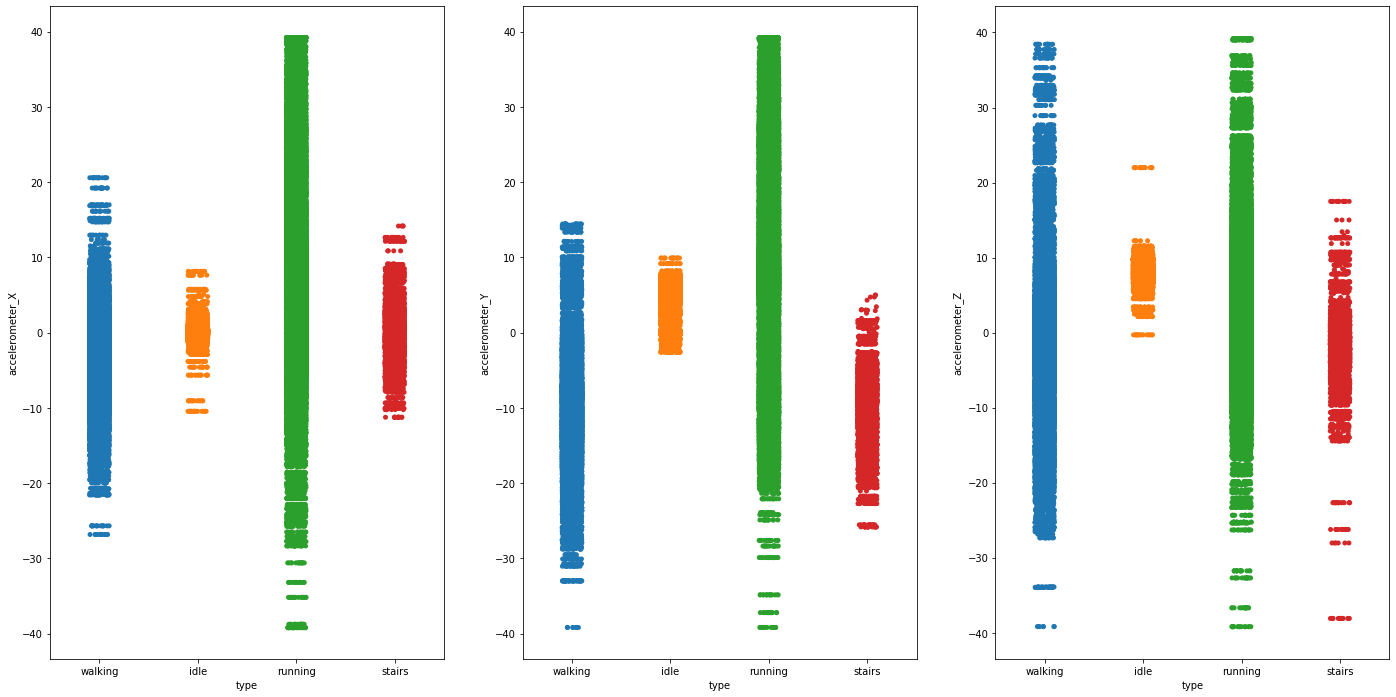

In [16]:
import seaborn as sns

fig=plt.figure(figsize=(24,12))
ax1=fig.add_subplot(131)
ax1=sns.stripplot(x='type',y='accelerometer_X',data=data_df,jitter=True)

ax2=fig.add_subplot(132)
ax2=sns.stripplot(x='type',y='accelerometer_Y',data=data_df,jitter=True)

ax3=fig.add_subplot(133)
ax3=sns.stripplot(x='type',y='accelerometer_Z',data=data_df,jitter=True)

plt.show()

**Conclutions:**

1. In data presented outliers
2. Data without NA's
3. We have difference more in std, and verity terms

## Train test split of files by type

In [18]:
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score

train_ids, test_ids = train_test_split(file_list, test_size=0.1, stratify=file_list['type'], random_state=2018)

len(train_ids), len(test_ids)

(5815, 647)

In [19]:
train_ids.columns, data_df.columns

(Index(['path', 'type', 'id'], dtype='object'),
 Index(['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'id', 'time',
        'type'],
       dtype='object'))

In [21]:
# X_train = data_df[data_df['id'].isin(train_ids['id'])].sort_values(["id", "time"]).drop(['type', 'id', 'time'], axis=1).copy()
# y_train = data_df[data_df['id'].isin(train_ids['id'])].sort_values(["id", "time"])['type'].values

# X_test = data_df[data_df['id'].isin(test_ids['id'])].sort_values(["id", "time"]).drop(['type', 'id', 'time'], axis=1).copy()
# y_test = data_df[data_df['id'].isin(test_ids['id'])].sort_values(["id", "time"])['type'].values

# X_train.shape, X_test.shape

# Features generation

## Fit RF classifier with using 30*3 measurements as features

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

def plot_results(estimator=None, X_test=None, y_test=None, y_pred=None):
    
    fig, ax = plt.subplots()
    
    if estimator is None:
        ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), np.unique(y_test))
        ax.set_title('Cross Validation result on X_train')
    else:
        plot_confusion_matrix(estimator, X_test, y_test,
                                 display_labels=np.unique(y_test),
                                 cmap=plt.cm.Blues,
                     values_format='.0f',
                     ax=ax)
        ax.set_title('Hold-Out result')
    plt.show()

In [23]:
simple_features = []

for arg in tqdm(data_list):
    temp = arg.pivot(index='id', columns='time', 
                       values=['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']
                      )
    temp.columns = ['__'.join([arg, str(num)]) for num in range(30)
                            for arg in ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
    temp['type'] = arg.type.unique()[0]
    temp['id'] = arg.id.unique()[0]

    simple_features.append(temp.reset_index(drop=True))
    
simple_features[0]

,accelerometer_X__0,accelerometer_Y__0,accelerometer_Z__0,accelerometer_X__1,accelerometer_Y__1,accelerometer_Z__1,accelerometer_X__2,accelerometer_Y__2,accelerometer_Z__2,accelerometer_X__3,accelerometer_Y__3,accelerometer_Z__3,accelerometer_X__4,accelerometer_Y__4,accelerometer_Z__4,accelerometer_X__5,accelerometer_Y__5,accelerometer_Z__5,accelerometer_X__6,accelerometer_Y__6,accelerometer_Z__6,accelerometer_X__7,accelerometer_Y__7,accelerometer_Z__7,accelerometer_X__8,accelerometer_Y__8,accelerometer_Z__8,accelerometer_X__9,accelerometer_Y__9,accelerometer_Z__9,accelerometer_X__10,accelerometer_Y__10,accelerometer_Z__10,accelerometer_X__11,accelerometer_Y__11,accelerometer_Z__11,accelerometer_X__12,accelerometer_Y__12,accelerometer_Z__12,accelerometer_X__13,accelerometer_Y__13,accelerometer_Z__13,accelerometer_X__14,accelerometer_Y__14,accelerometer_Z__14,accelerometer_X__15,accelerometer_Y__15,accelerometer_Z__15,accelerometer_X__16,accelerometer_Y__16,accelerometer_Z__16,accelerometer_X__17,accelerometer_Y__17,accelerometer_Z__17,accelerometer_X__18,accelerometer_Y__18,accelerometer_Z__18,accelerometer_X__19,accelerometer_Y__19,accelerometer_Z__19,accelerometer_X__20,accelerometer_Y__20,accelerometer_Z__20,accelerometer_X__21,accelerometer_Y__21,accelerometer_Z__21,accelerometer_X__22,accelerometer_Y__22,accelerometer_Z__22,accelerometer_X__23,accelerometer_Y__23,accelerometer_Z__23,accelerometer_X__24,accelerometer_Y__24,accelerometer_Z__24,accelerometer_X__25,accelerometer_Y__25,accelerometer_Z__25,accelerometer_X__26,accelerometer_Y__26,accelerometer_Z__26,accelerometer_X__27,accelerometer_Y__27,accelerometer_Z__27,accelerometer_X__28,accelerometer_Y__28,accelerometer_Z__28,accelerometer_X__29,accelerometer_Y__29,accelerometer_Z__29,type,id
0,-7.398083,-5.39653,-4.582502,-9.873688,-3.936067,-1.733402,-2.925714,0.220267,2.48997,-3.442862,-14.973337,-2.772485,-12.430696,-4.118027,-0.363919,-5.080496,-8.772355,-4.055777,-4.070143,-9.303867,0.790087,-2.916138,-3.174711,-8.020575,-3.260903,-3.931279,-14.45619,1.431733,-2.011129,-1.877054,-13.077129,-9.093178,-14.00608,-13.512875,-12.339716,-5.492298,-7.062895,-9.337387,-22.471977,-12.129025,-6.234501,-13.929465,-9.524135,-8.030152,-3.083732,-8.508993,-13.833697,-8.959103,-12.933477,-14.441825,-12.253524,-2.60968,-9.629479,-14.662091,-3.064578,-14.068329,-15.107412,-12.698846,-1.403002,-9.428367,-1.541866,-0.033519,0.866701,-13.302185,-1.058237,-5.228936,0.110133,3.519477,-3.806781,-1.177947,-11.702858,-0.646434,-12.808979,-0.775721,1.091756,0.248997,-0.823605,0.09098,5.31034,-7.800309,-1.575385,1.675941,-1.94888,-1.527501,37.138855,6.052542,-13.393165,-2.408567,2.097321,-2.499546,walking,walking-1422


In [24]:
simple_df = pd.concat(simple_features, axis=0, sort=False)
simple_df.shape

(6462, 92)

In [25]:
X_train = simple_df[simple_df['id'].isin(train_ids['id'])].drop(['type', 'id'], axis=1).copy()
y_train = simple_df[simple_df['id'].isin(train_ids['id'])]['type'].values

X_test = simple_df[simple_df['id'].isin(test_ids['id'])].drop(['type', 'id'], axis=1).copy()
y_test = simple_df[simple_df['id'].isin(test_ids['id'])]['type'].values

X_train.shape, X_test.shape

((5815, 90), (647, 90))

In [26]:
preds_cv = cross_val_predict(RandomForestClassifier(class_weight='balanced', n_jobs=-1), 
                             X_train, y_train, groups=y_train, cv=5, verbose=1)

print(classification_report(y_train, preds_cv, digits=4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

        idle     1.0000    1.0000    1.0000       935
     running     1.0000    1.0000    1.0000      3067
      stairs     1.0000    0.0878    0.1615       148
     walking     0.9250    1.0000    0.9610      1665

    accuracy                         0.9768      5815
   macro avg     0.9812    0.7720    0.7806      5815
weighted avg     0.9785    0.9768    0.9675      5815



[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.0s finished


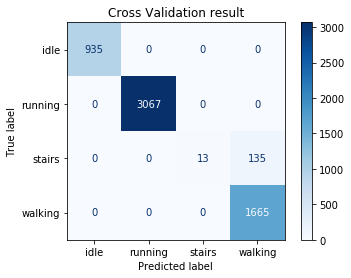

In [27]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_train, preds_cv), display_labels=np.unique(y_train)
                      ).plot(cmap=plt.cm.Blues,
                             values_format='.0f',
                            ax=ax)
ax.set_title('Cross Validation result')
plt.show()

In [28]:
classifier_full = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
classifier_full.fit(X_train, y_train)
preds_test = classifier_full.predict(X_test)

print(classification_report(y_test, preds_test, digits=4))

              precision    recall  f1-score   support

        idle     1.0000    1.0000    1.0000       104
     running     1.0000    1.0000    1.0000       341
      stairs     1.0000    0.1765    0.3000        17
     walking     0.9296    1.0000    0.9635       185

    accuracy                         0.9784       647
   macro avg     0.9824    0.7941    0.8159       647
weighted avg     0.9799    0.9784    0.9712       647



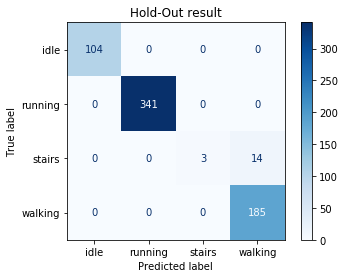

In [29]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test), display_labels=np.unique(y_test)
                      ).plot(cmap=plt.cm.Blues,
                             values_format='.0f',
                            ax=ax)
ax.set_title('Hold-Out result')
plt.show()

In [31]:
# check classes in confution matrix
np.unique(y_test, return_counts=True)

(array(['idle', 'running', 'stairs', 'walking'], dtype=object),
 array([104, 341,  17, 185]))

**Conclusions:**

1. We had big issue with __stairs__ class. Model isn't recognize it, and predict as __walking__.

## Build features with TSFresh library

In [32]:
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute

In [33]:
X_all_gen = extract_features(data_df.sort_values(["id", "time"]).drop(['type'], axis=1).copy(), 
                               column_id="id", 
                               column_sort="time", 
                               impute_function=impute,
                              n_jobs=20)

X_all_gen.shape

Feature Extraction: 100%|██████████| 100/100 [01:25<00:00,  1.16it/s]


(6462, 2289)

In [38]:
X_all_gen['type'] = X_all_gen.index.map(lambda x: x.split('-')[0])

X_all_gen['type'].value_counts()

running    3408
walking    1850
idle       1039
stairs      165
Name: type, dtype: int64

In [40]:
X_train_gen = X_all_gen[X_all_gen.index.isin(train_ids['id'])].drop(['type'], axis=1).copy()
y_train = X_all_gen[X_all_gen.index.isin(train_ids['id'])]['type'].values

X_test_gen = X_all_gen[X_all_gen.index.isin(test_ids['id'])].drop(['type'], axis=1).copy()
y_test = X_all_gen[X_all_gen.index.isin(test_ids['id'])]['type'].values

X_train_gen.shape, X_test_gen.shape, len(y_train), len(y_test)

((5815, 2289), (647, 2289), 5815, 647)

In [41]:
np.unique(y_train, return_counts=True), np.unique(y_test, return_counts=True)

((array(['idle', 'running', 'stairs', 'walking'], dtype=object),
  array([ 935, 3067,  148, 1665])),
 (array(['idle', 'running', 'stairs', 'walking'], dtype=object),
  array([104, 341,  17, 185])))

## Filter features based on X_train

In [44]:
relevant_features = set()

for label in np.unique(y_train):
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train_gen, y_train_binary)
    print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X_train.shape[1]))
    relevant_features = relevant_features.union(set(X_train_filtered.columns))
    
len(relevant_features)

Number of relevant features for class idle: 758/90
Number of relevant features for class running: 754/90
Number of relevant features for class stairs: 550/90
Number of relevant features for class walking: 740/90


841

In [45]:
X_train_filtered = X_train_gen[list(relevant_features)]
X_test_filtered = X_test_gen[list(relevant_features)]

X_train_filtered.shape, X_test_filtered.shape

((5815, 841), (647, 841))

## Check filtered features on Random Forest baseline model

In [46]:
preds_cv = cross_val_predict(RandomForestClassifier(class_weight='balanced', n_jobs=-1), 
                             X_train_filtered, y_train, groups=y_train, cv=10, verbose=1)

print(classification_report(y_train, preds_cv, digits=4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

        idle     1.0000    1.0000    1.0000       935
     running     1.0000    1.0000    1.0000      3067
      stairs     0.9592    0.6351    0.7642       148
     walking     0.9685    0.9976    0.9828      1665

    accuracy                         0.9900      5815
   macro avg     0.9819    0.9082    0.9368      5815
weighted avg     0.9899    0.9900    0.9891      5815



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.1s finished


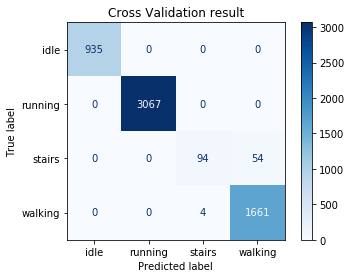

In [47]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_train, preds_cv), display_labels=np.unique(y_train)
                      ).plot(cmap=plt.cm.Blues,
                             values_format='.0f',
                            ax=ax)
ax.set_title('Cross Validation result')
plt.show()

In [48]:
classifier_full = RandomForestClassifier(class_weight='balanced', n_jobs=-1)
classifier_full.fit(X_train_filtered, y_train)
preds_test = classifier_full.predict(X_test_filtered)

print(classification_report(y_test, preds_test, digits=4))

              precision    recall  f1-score   support

        idle     1.0000    1.0000    1.0000       104
     running     1.0000    1.0000    1.0000       341
      stairs     1.0000    1.0000    1.0000        17
     walking     1.0000    1.0000    1.0000       185

    accuracy                         1.0000       647
   macro avg     1.0000    1.0000    1.0000       647
weighted avg     1.0000    1.0000    1.0000       647



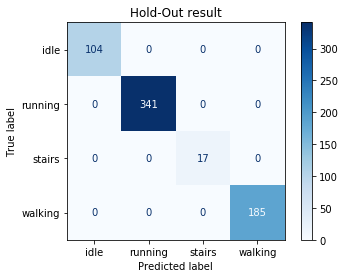

In [49]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_test, preds_test), display_labels=np.unique(y_test)
                      ).plot(cmap=plt.cm.Blues,
                             values_format='.0f',
                            ax=ax)
ax.set_title('Hold-Out result')
plt.show()

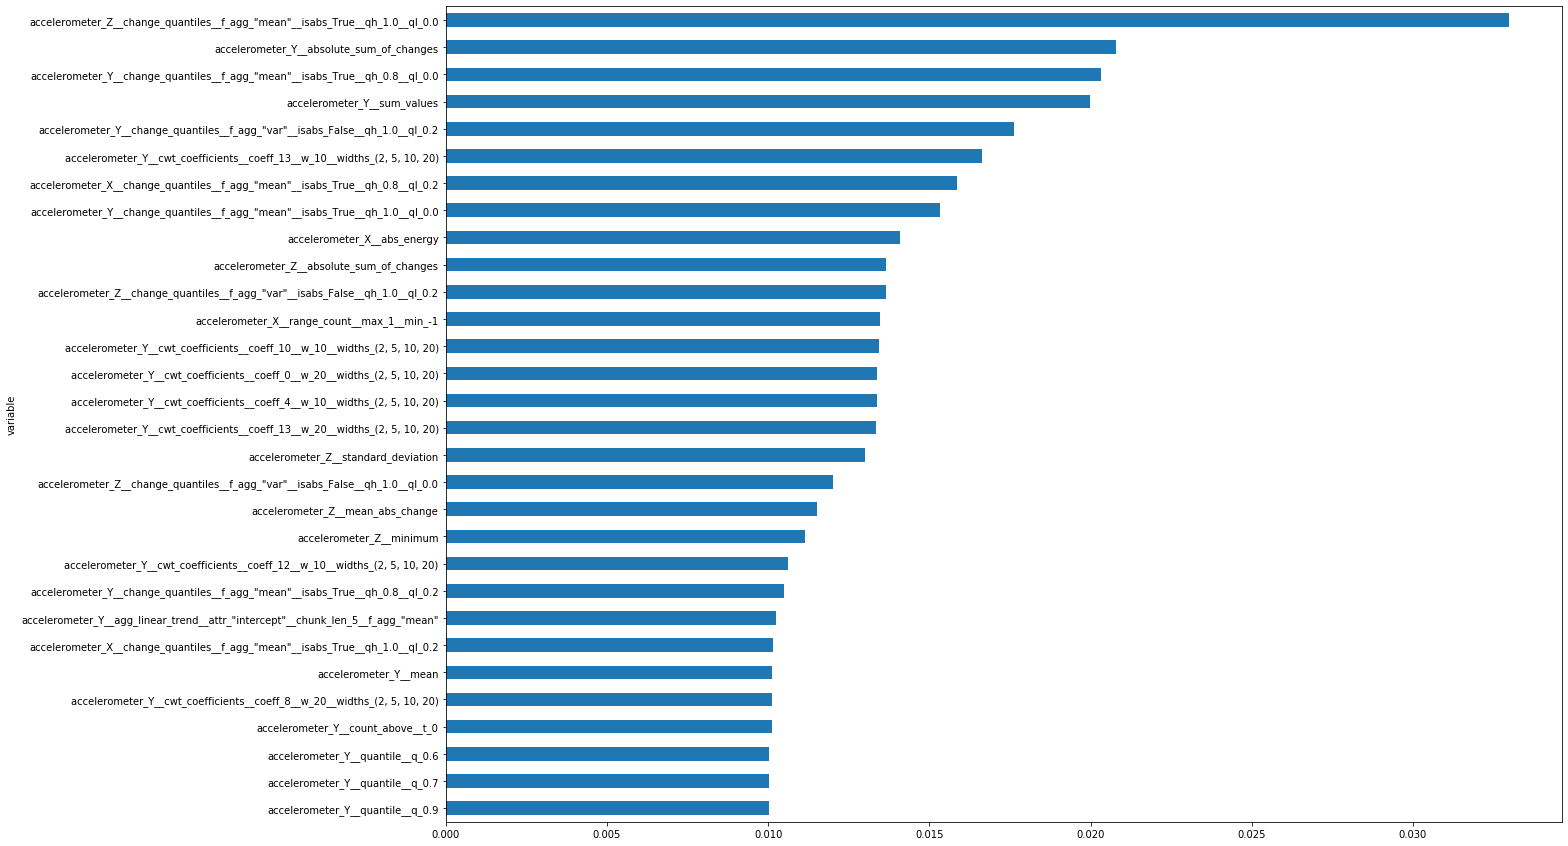

In [90]:
fig, ax = plt.subplots(figsize=(20,15))
feat_importances = pd.Series(classifier_full.feature_importances_, index=X_train_filtered.columns)
feat_importances.nlargest(30)[::-1,].plot(kind='barh', ax=ax)
plt.show()

**Conclusions:**

1. HoldOut dataset the best :-)

## Understanding issue with prediction __stairs__ class on TSNE projection

In [51]:
X_all = X_all_gen[list(relevant_features)].copy()
y_all = X_all_gen.reset_index()['id'].apply(lambda x: x.split('-')[0]).values

np.unique(y_all, return_counts=True), len(X_all), len(y_all)

((array(['idle', 'running', 'stairs', 'walking'], dtype=object),
  array([1039, 3408,  165, 1850])),
 6462,
 6462)

In [52]:
preds_cv = cross_val_predict(RandomForestClassifier(class_weight='balanced', n_jobs=-1), 
                             X_all, y_all, groups=y_all, cv=10, verbose=1)

print(classification_report(y_all, preds_cv, digits=4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   19.3s finished


              precision    recall  f1-score   support

        idle     1.0000    1.0000    1.0000      1039
     running     1.0000    1.0000    1.0000      3408
      stairs     0.9909    0.6606    0.7927       165
     walking     0.9706    0.9995    0.9848      1850

    accuracy                         0.9912      6462
   macro avg     0.9904    0.9150    0.9444      6462
weighted avg     0.9914    0.9912    0.9904      6462



### 2D projection

In [53]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
X_all_scaled = pd.DataFrame(min_max.fit_transform(X_all), columns=X_all.columns)

In [54]:
X_embedded = TSNE(n_components=2, n_jobs=-1).fit_transform(X_all_scaled)

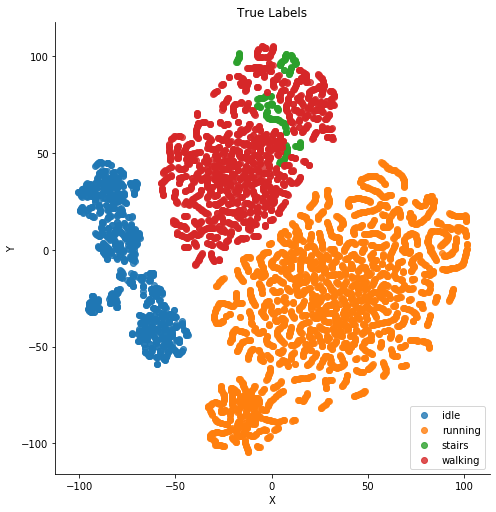

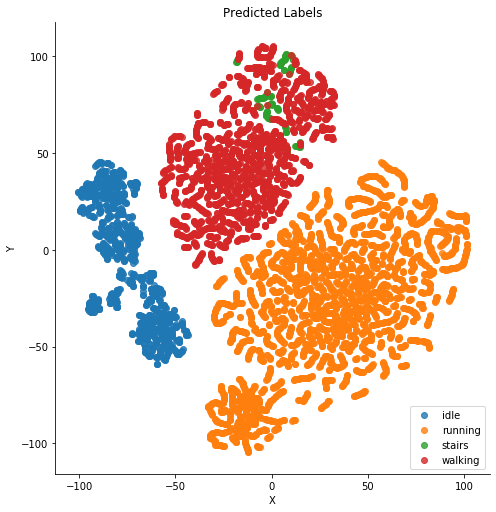

In [55]:
import seaborn as sns

tsne_data = pd.DataFrame(X_embedded, columns=['X', 'Y'])
tsne_data['y_true'] = y_all
tsne_data['y_pred'] = preds_cv
tsne_data['errors'] = y_all != preds_cv

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="X", y="Y", data=tsne_data, fit_reg=False, hue='y_true', legend=False, height=7)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.title('True Labels')
plt.show()

# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="X", y="Y", data=tsne_data, fit_reg=False, hue='y_pred', legend=False, height=7)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.title('Predicted Labels')
plt.show()

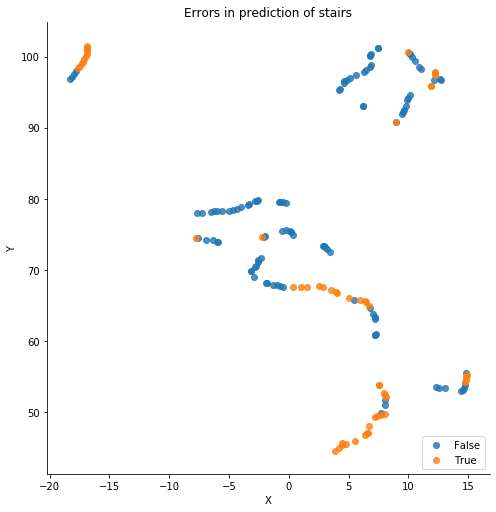

In [56]:
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="X", y="Y", data=tsne_data.query("y_true == 'stairs'"), fit_reg=False, hue='errors', legend=False, height=7)
 
# Move the legend to an empty part of the plot
plt.legend(loc='lower right')
plt.title('Errors in prediction of stairs')
plt.show()

### 3D projection

In [57]:
X_embedded_3 = TSNE(n_components=3, n_jobs=-1).fit_transform(X_all_scaled)

In [64]:
tsne_data = pd.DataFrame(X_embedded_3, columns=['X', 'Y', 'Z'])
tsne_data['y_true'] = y_all
tsne_data['y_pred'] = preds_cv
tsne_data['errors'] = y_all != preds_cv

tsne_data.head()

,X,Y,Z,y_true,y_pred,errors
0,-7.070371,1.804104,24.100874,idle,idle,False
1,-13.469281,6.266315,21.726818,idle,idle,False
2,-9.837099,2.957528,10.915601,idle,idle,False
3,-17.659216,2.991901,9.352824,idle,idle,False
4,-17.665905,3.036580,9.363270,idle,idle,False


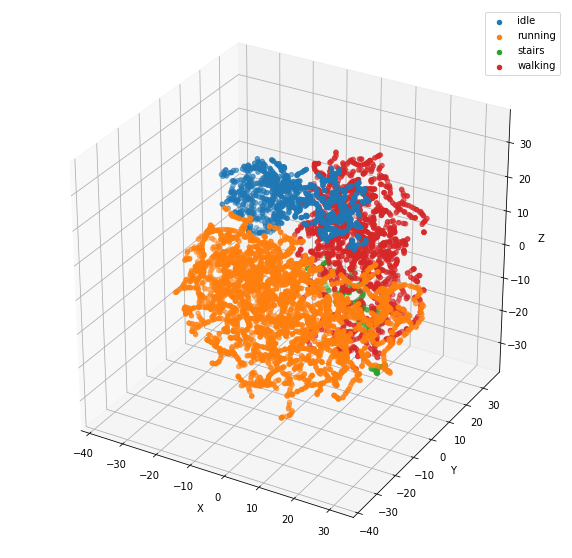

In [76]:
from mpl_toolkits.mplot3d import Axes3D

ax = plt.figure(figsize=(10,10)).gca(projection='3d')
for arg in tsne_data["y_true"].unique():
    ax.scatter(
        xs=tsne_data.loc[tsne_data["y_true"] == arg,"X"], 
        ys=tsne_data.loc[tsne_data["y_true"] == arg,"Y"], 
        zs=tsne_data.loc[tsne_data["y_true"] == arg,"Z"],  
#         c=class_int_dict[arg],
        label=arg,
        cmap='tab10'
    )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

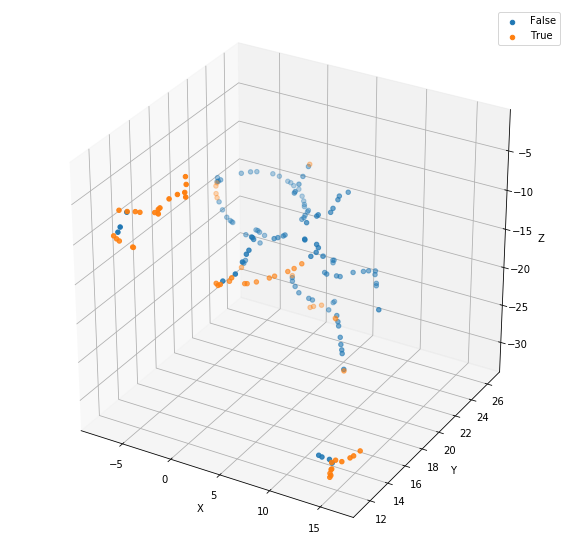

In [79]:
ax = plt.figure(figsize=(10,10)).gca(projection='3d')
for arg in tsne_data["errors"].unique():
    ax.scatter(
        xs=tsne_data.query("y_true == 'stairs'").loc[tsne_data["errors"] == arg,"X"], 
        ys=tsne_data.query("y_true == 'stairs'").loc[tsne_data["errors"] == arg,"Y"], 
        zs=tsne_data.query("y_true == 'stairs'").loc[tsne_data["errors"] == arg,"Z"],  
#         c=class_int_dict[arg],
        label=arg,
        cmap='tab10'
    )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.show()

In [80]:
preds_cv = cross_val_predict(RandomForestClassifier(class_weight='balanced', n_jobs=-1), 
                             X_embedded_3, y_all, groups=y_all, cv=10, verbose=1)

print(classification_report(y_all, preds_cv, digits=4))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

        idle     0.9961    0.9923    0.9942      1039
     running     0.9892    0.9938    0.9915      3408
      stairs     0.6197    0.5333    0.5733       165
     walking     0.9479    0.9535    0.9507      1850

    accuracy                         0.9703      6462
   macro avg     0.8882    0.8682    0.8774      6462
weighted avg     0.9690    0.9703    0.9696      6462



[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.5s finished


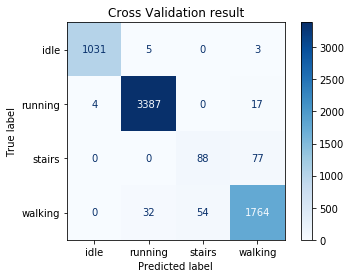

In [81]:
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix(y_all, preds_cv), display_labels=np.unique(y_all)
                      ).plot(cmap=plt.cm.Blues,
                             values_format='.0f',
                            ax=ax)
ax.set_title('Cross Validation result')
plt.show()

**Conclusions:**
1. Based on visualizations and errors of baseline model, let's try more smart model with tuning parameters.